# Applying corrections to columnar data

Here we will show how to apply corrections to columnar data using:

- the `coffea.lookup_tools` package, which is designed to read in ROOT histograms and a variety of data file formats popular within CMS into a standardized lookup table format;
- CMS-specific extensions to the above, for jet corrections (`coffea.jetmet_tools`) and b-tagging efficiencies/uncertainties (`coffea.btag_tools`);
- the [correctionlib](https://cms-nanoaod.github.io/correctionlib/) package, which provides a experiment-agnostic serializable data format for common correction functions.

**Test data**:
We'll use NanoEvents to construct some test data.

In [1]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

fname = "https://raw.githubusercontent.com/CoffeaTeam/coffea/master/tests/samples/nano_dy.root"
events = NanoEventsFactory.from_root(
    fname,
    schemaclass=NanoAODSchema.v6,
    metadata={"dataset": "DYJets"},
).events()

## Coffea lookup_tools

The entrypoint for `coffea.lookup_tools` is the [extractor class](https://coffeateam.github.io/coffea/api/coffea.lookup_tools.extractor.html#coffea.lookup_tools.extractor).

In [2]:
from coffea.lookup_tools import extractor

In [3]:
%%bash
# download some sample correction sources
mkdir -p data
pushd data
PREFIX=https://raw.githubusercontent.com/CoffeaTeam/coffea/master/tests/samples
curl -Os $PREFIX/testSF2d.histo.root
curl -Os $PREFIX/Fall17_17Nov2017_V32_MC_L2Relative_AK4PFPuppi.jec.txt
curl -Os $PREFIX/Fall17_17Nov2017_V32_MC_Uncertainty_AK4PFPuppi.junc.txt
curl -Os $PREFIX/DeepCSV_102XSF_V1.btag.csv.gz
popd

~/src/coffea/binder/data ~/src/coffea/binder
~/src/coffea/binder


### Opening a root file and using it as a lookup table

In [tests/samples](https://github.com/CoffeaTeam/coffea/tree/master/tests/samples), there is an example file with a `TH2F` histogram named `scalefactors_Tight_Electron`. The following code reads that histogram into an [evaluator](https://coffeateam.github.io/coffea/api/coffea.lookup_tools.evaluator.html#coffea.lookup_tools.evaluator) instance, under the key `testSF2d` and applies it to some electrons.

In [4]:
ext = extractor()
# several histograms can be imported at once using wildcards (*)
ext.add_weight_sets(["testSF2d scalefactors_Tight_Electron data/testSF2d.histo.root"])
ext.finalize()

evaluator = ext.make_evaluator()

print("available evaluator keys:")
for key in evaluator.keys():
    print("\t", key)
print("testSF2d:", evaluator['testSF2d'])
print("type of testSF2d:", type(evaluator['testSF2d']))

available evaluator keys:
	 testSF2d
testSF2d: 2 dimensional histogram with axes:
	1: [-2.5   -2.    -1.566 -1.444 -0.8    0.     0.8    1.444  1.566  2.
  2.5  ]
	2: [ 10.  20.  35.  50.  90. 150. 500.]

type of testSF2d: <class 'coffea.lookup_tools.dense_lookup.dense_lookup'>


In [5]:
print("Electron eta:", events.Electron.eta)
print("Electron pt:", events.Electron.pt)
print("Scale factor:", evaluator["testSF2d"](events.Electron.eta, events.Electron.pt))

Electron eta: [[], [1.83], [-0.293, -0.904], [-2.19, 1.65], ... [-0.0595], [], [0.381], [], []]
Electron pt: [[], [29.6], [60.1, 51.7], [10.7, 8.6], [], ... [], [15.6], [], [7.68], [], []]
Scale factor: [[], [0.909], [0.953, 0.972], [0.807, 0.827], ... [0.941], [], [0.946], [], []]


### Building and using your own correction from a histogram

To use a histogram or ratio of histograms to build your own correction, you can use `lookup_tools` to simplify the implementation. Here we create some mock data for two slightly different pt and eta spectra (say, from two different generators) and derive a correction to reweight one sample to the other.

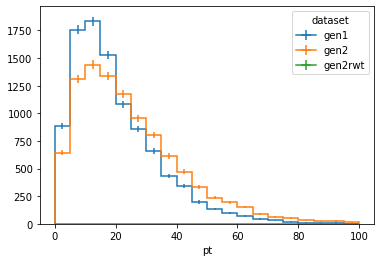

In [6]:
import numpy as np
import hist
import matplotlib.pyplot as plt

dists = (
    hist.Hist.new
    .StrCat(["gen1", "gen2", "gen2rwt"], name="dataset")
    .Reg(20, 0, 100, name="pt")
    .Reg(4, -3, 3, name="eta")
    .Weight()
    .fill(
        dataset="gen1",
        pt=np.random.exponential(scale=10.0, size=10000) + np.random.exponential(scale=10.0, size=10000),
        eta=np.random.normal(scale=1, size=10000)
    )
    .fill(
        dataset="gen2",
        pt=np.random.exponential(scale=10.0, size=10000) + np.random.exponential(scale=15.0, size=10000),
        eta=np.random.normal(scale=1.1, size=10000)
    )
)

fig, ax = plt.subplots()
dists[:, :, sum].plot1d(ax=ax)
ax.legend(title="dataset")

Now we derive a correction as a function of $p_T$ and $\eta$ to `gen2` such that it agrees with `gen1`. We'll set it to 1 anywhere we run out of statistics for the correction, to avoid divide by zero issues

2 dimensional histogram with axes:
	1: [  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100.]
	2: [-3.  -1.5  0.   1.5  3. ]



ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x134eac6a0>, cbar=<matplotlib.colorbar.Colorbar object at 0x134eb87c0>, text=[])

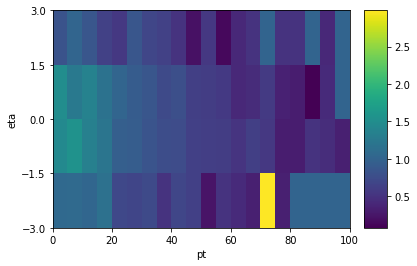

In [7]:
from coffea.lookup_tools.dense_lookup import dense_lookup

num = dists["gen1", :, :].values()
den = dists["gen2", :, :].values()
sf = np.where(
    (num > 0) & (den > 0),
    num / np.maximum(den, 1) * den.sum() / num.sum(),
    1.0,
)

corr = dense_lookup(sf, [ax.edges for ax in dists.axes[1:]])
print(corr)

# a quick way to plot the scale factor is to steal the axis definitions from the input histograms:
sfhist = hist.Hist(*dists.axes[1:], data=sf)
sfhist.plot2d()

Now we generate some new mock data as if it was drawn from `gen2` and reweight it with our `corr` to match `gen1`

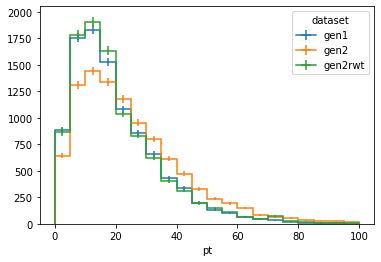

In [8]:
ptvals = np.random.exponential(scale=10.0, size=10000) + np.random.exponential(scale=15.0, size=10000)
etavals = np.random.normal(scale=1.1, size=10000)

dists.fill(
    dataset="gen2rwt",
    pt=ptvals,
    eta=etavals,
    weight=corr(ptvals, etavals)
)

fig, ax = plt.subplots()
dists[:, :, sum].plot1d(ax=ax)
ax.legend(title="dataset")

Note that `corr()` can accept also jagged arrays if need be.

## CMS high-level tools

### Applying energy scale transformations with jetmet_tools

The `coffea.jetmet_tools` package provides a convenience class [JetTransformer](https://coffeateam.github.io/coffea/api/coffea.jetmet_tools.JetTransformer.html#coffea.jetmet_tools.JetTransformer) which applies specified corrections and computes uncertainties in one call. First we build the desired jet correction stack to apply. This will usually be some set of the various JEC and JER correction text files that depends on the jet cone size (AK4, AK8) and the pileup mitigation algorithm, as well as the data-taking year they are associated with.

In [9]:
from coffea.jetmet_tools import FactorizedJetCorrector, JetCorrectionUncertainty
from coffea.jetmet_tools import JECStack, CorrectedJetsFactory
import awkward as ak
import numpy as np

ext = extractor()
ext.add_weight_sets([
    "* * data/Fall17_17Nov2017_V32_MC_L2Relative_AK4PFPuppi.jec.txt",
    "* * data/Fall17_17Nov2017_V32_MC_Uncertainty_AK4PFPuppi.junc.txt",
])
ext.finalize()

jec_stack_names = [
    "Fall17_17Nov2017_V32_MC_L2Relative_AK4PFPuppi",
    "Fall17_17Nov2017_V32_MC_Uncertainty_AK4PFPuppi"
]

evaluator = ext.make_evaluator()

jec_inputs = {name: evaluator[name] for name in jec_stack_names}
jec_stack = JECStack(jec_inputs)
### more possibilities are available if you send in more pieces of the JEC stack
# mc2016_ak8_jxform = JECStack(["more", "names", "of", "JEC parts"])

print(dir(evaluator))

['Fall17_17Nov2017_V32_MC_L2Relative_AK4PFPuppi', 'Fall17_17Nov2017_V32_MC_Uncertainty_AK4PFPuppi']


Now we prepare some auxilary variables that are used to parameterize the jet energy corrections, such as jet area, mass, and event $\rho$ (mean pileup energy density), and pass all of these into the `CorrectedJetsFactory`:

In [10]:
name_map = jec_stack.blank_name_map
name_map['JetPt'] = 'pt'
name_map['JetMass'] = 'mass'
name_map['JetEta'] = 'eta'
name_map['JetA'] = 'area'

jets = events.Jet
    
jets['pt_raw'] = (1 - jets['rawFactor']) * jets['pt']
jets['mass_raw'] = (1 - jets['rawFactor']) * jets['mass']
jets['pt_gen'] = ak.values_astype(ak.fill_none(jets.matched_gen.pt, 0), np.float32)
jets['rho'] = ak.broadcast_arrays(events.fixedGridRhoFastjetAll, jets.pt)[0]
name_map['ptGenJet'] = 'pt_gen'
name_map['ptRaw'] = 'pt_raw'
name_map['massRaw'] = 'mass_raw'
name_map['Rho'] = 'rho'
    
events_cache = events.caches[0]
corrector = FactorizedJetCorrector(
    Fall17_17Nov2017_V32_MC_L2Relative_AK4PFPuppi=evaluator['Fall17_17Nov2017_V32_MC_L2Relative_AK4PFPuppi'],
)
uncertainties = JetCorrectionUncertainty(
    Fall17_17Nov2017_V32_MC_Uncertainty_AK4PFPuppi=evaluator['Fall17_17Nov2017_V32_MC_Uncertainty_AK4PFPuppi']
)

jet_factory = CorrectedJetsFactory(name_map, jec_stack)
corrected_jets = jet_factory.build(jets, lazy_cache=events_cache)

print('starting columns:', set(ak.fields(jets)))
print('new columns:', set(ak.fields(corrected_jets)) - set(ak.fields(jets)))

starting columns: {'btagCSVV2', 'electronIdx1', 'electronIdx2', 'eta', 'muonSubtrFactor', 'btagCMVA', 'bRegCorr', 'btagDeepFlavB', 'jercCHPUF', 'chEmEF', 'pt_raw', 'muonIdx2', 'nMuons', 'cleanmask', 'muonIdx1G', 'genJetIdxG', 'puId', 'muEF', 'mass', 'genJetIdx', 'muonIdx1', 'area', 'hadronFlavour', 'btagDeepC', 'qgl', 'rawFactor', 'mass_raw', 'partonFlavour', 'phi', 'btagDeepFlavC', 'nElectrons', 'electronIdx2G', 'rho', 'btagDeepB', 'neHEF', 'pt_gen', 'muonIdx2G', 'neEmEF', 'electronIdx1G', 'jercCHF', 'muonIdxG', 'jetId', 'nConstituents', 'electronIdxG', 'bRegRes', 'pt', 'chHEF'}
new columns: {'jet_energy_correction', 'mass_orig', 'pt_orig', 'pt_jec', 'JES_jes', 'mass_jec', 'jet_energy_uncertainty_jes'}


Below we show that the corrected jets indeed have a different $p_T$ and mass than we started with

In [11]:
print('untransformed pt ratios', jets.pt/jets.pt_raw)
print('untransformed mass ratios', jets.mass/jets.mass_raw)

print('transformed pt ratios', corrected_jets.pt/corrected_jets.pt_raw)
print('transformed mass ratios', corrected_jets.mass/corrected_jets.mass_raw)

print('JES UP pt ratio', corrected_jets.JES_jes.up.pt/corrected_jets.pt_raw)
print('JES DOWN pt ratio', corrected_jets.JES_jes.down.pt/corrected_jets.pt_raw)

untransformed pt ratios [[1.12, 1.09, 1.2, 1.35, 1.27], [1.03, ... 1.28, 1.1, 1.13, 0.989], [1.13, 0.978]]
untransformed mass ratios [[1.12, 1.09, 1.2, 1.35, 1.27], [1.03, ... 1.28, 1.1, 1.13, 0.989], [1.13, 0.978]]
transformed pt ratios [[1.2, 1.3, 1.46, 2.09, 2.1], [1.09, 1.29, ... 1.84, 1.47, 1.36, 1.16], [1.37, 1.15]]
transformed mass ratios [[1.2, 1.3, 1.46, 2.09, 2.1], [1.09, 1.29, ... 1.84, 1.47, 1.36, 1.16], [1.37, 1.15]]
JES UP pt ratio [[1.22, 1.35, 1.56, 2.34, 2.37], [1.1, ... 2.07, 1.52, 1.41, 1.2], [1.41, 1.17]]
JES DOWN pt ratio [[1.19, 1.25, 1.35, 1.83, 1.83], [1.08, ... 1.6, 1.41, 1.32, 1.13], [1.33, 1.12]]


### Applying CMS b-tagging corrections with btag_tools
The `coffea.btag_tools` module provides the high-level utility [BTagScaleFactor](https://coffeateam.github.io/coffea/api/coffea.btag_tools.BTagScaleFactor.html#coffea.btag_tools.BTagScaleFactor) which calculates per-jet weights for b-tagging as well as light flavor mis-tagging efficiencies. Uncertainties can be calculated as well.

In [12]:
from coffea.btag_tools import BTagScaleFactor

btag_sf = BTagScaleFactor("data/DeepCSV_102XSF_V1.btag.csv.gz", "medium")

print("SF:", btag_sf.eval("central", events.Jet.hadronFlavour, abs(events.Jet.eta), events.Jet.pt))
print("systematic +:", btag_sf.eval("up", events.Jet.hadronFlavour, abs(events.Jet.eta), events.Jet.pt))
print("systematic -:", btag_sf.eval("down", events.Jet.hadronFlavour, abs(events.Jet.eta), events.Jet.pt))

SF: [[1.52, 1.56, 1.59, 1.6, 1.6], [0.969, 1.57, ... 1.59, 1.6, 1.6, 1.6], [1.6, 1.6]]
systematic +: [[1.72, 1.77, 1.79, 1.8, 1.8], [1.01, 1.78, ... 1.8, 1.8, 1.8, 1.8], [1.8, 1.8]]
systematic -: [[1.31, 1.36, 1.38, 1.4, 1.4], [0.925, 1.37, ... 1.39, 1.4, 1.4, 1.4], [1.4, 1.4]]


## Using correctionlib

For the most part, using correctionlib is straightforward. We'll show here how to convert the custom correction we derived earlier (`corr`) into a correctionlib object, and save it in the json format:

In [13]:
import correctionlib, rich
import correctionlib.convert

# without a name, the resulting object will fail validation
sfhist.name = "gen2_to_gen1"
sfhist.label = "out"
clibcorr = correctionlib.convert.from_histogram(sfhist)
clibcorr.description = "Reweights gen2 to agree with gen1"
# set overflow bins behavior (default is to raise an error when out of bounds)
clibcorr.data.flow = "clamp"

cset = correctionlib.schemav2.CorrectionSet(
    schema_version=2,
    description="my custom corrections",
    corrections=[clibcorr],
)
rich.print(cset)

with open("data/mycorrections.json", "w") as fout:
    fout.write(cset.json(exclude_unset=True))

CorrectionSet (schema v2)                                                                    
my custom corrections                                                                        
📂                                                                                           
└── 📈 gen2_to_gen1 (v0)                                                                     
    Reweights gen2 to agree with gen1                                                        
    Node counts: MultiBinning: 1                                                             
    ╭──────────── ▶ input ─────────────╮ ╭──────────── ▶ input ────────────╮                 
    │ pt (real)                        │ │ eta (real)                      │                 
    │ pt                               │ │ eta                             │                 
    │ Range: [0.0, 100.0), overflow ok │ │ Range: [-3.0, 3.0), overflow ok │                 
    ╰──────────────────────────────────╯ ╰─────────────────────────────────╯                 
    ╭─── ◀ output ───╮                                                                       
    │ out (real)     │                                                                       
    │ No description │                                                                       
    ╰────────────────╯

We can now use this new correction in a similar way to the original `corr()` object:

In [14]:
ceval = cset.to_evaluator()

ceval["gen2_to_gen1"].evaluate(ptvals, etavals)

array([1.55691586, 1.36319225, 1.36319225, ..., 1.55691586, 0.64304079,
       1.02863368])

At the time of writing, `correctionlib` does not support jagged arrays. A `correctionlib_wrapper` provided in `coffea.lookup_tools` allows for the processing of jagged array inputs.

In [15]:
from coffea.lookup_tools.correctionlib_wrapper import correctionlib_wrapper

wrap_c = correctionlib_wrapper(ceval["gen2_to_gen1"])
wrap_c(events.Jet.pt, events.Jet.eta)

<Array [[0.994, 0.313, 1.08, 0.904, 0.904], ...] type='40 * var * float64'>

Alternatively, we can use the awkward utilities `flatten` and `unflatten` to convert awkward arrays into numpy arrays for evaluation.

In [16]:
def myJetSF(jets):
    j, nj = ak.flatten(jets), ak.num(jets)
    sf = ceval["gen2_to_gen1"].evaluate(np.array(j.pt), np.array(j.eta))
    return ak.unflatten(sf, nj)

myJetSF(events.Jet)

<Array [[0.994, 0.313, 1.08, 0.904, 0.904], ...] type='40 * var * float64'>